In [1]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join
from functools import reduce
from operator import mul

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model
from module_update_phycobilisomes import add_OCP

In [2]:
from functions_custom_steady_state_simulator import simulate_to_steady_state_custom, _find_steady_state, get_response_coefficients, get_response_coefficients_array, get_response_coefficients_df, calculate_ss_Q_red, get_steadystate_y0

In [3]:
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

# Original 435 nm PAM-SP experiment

## Unfinished

In [ ]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

### Get the PAM and strain data

In [ ]:
def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,str(light)] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,str(growthlight)]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,str(growthlight)]), fraction_is_monomers=True, output_is_monomers=False)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def _plot_model_and_data(s, data, sim_offset=None, data_offset=None, ax=None):
    # Initialise a plot
    if ax is None:
        fig, ax = plt.subplots(**fnc.plt_defaults["figure"])
    else:
        fig = ax.figure

    # Align data and model using an offset
    if sim_offset is None:
        time = s.get_time()
    elif s.get_time()[0] != (-sim_offset):
        time = np.array(s.get_time())- (s.get_time()[0] + sim_offset)
    else:
        time = s.get_time()

    # Plot the data
    dat = data/data.max().max()
    dat_time = dat.index

    if data_offset is not None:
        dat_time -= data_offset
    dat_line = ax.plot(dat_time, dat.values, c="firebrick", label="Measurement")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluorescence [rel.]")
    ax.set_ylim(ymin=0)

    # Plot the simulation on top
    fluo = s.get_full_results_dict()["Fluo"]
    fluo_norm = fluo / fluo.max()
    sim_line = ax.plot(time, fluo_norm, c="black", label="Simulation")

    if len(dat_line)>1:
        handles = sim_line + dat_line[0]
    else:
        handles = sim_line + dat_line

    ax.legend(
        handles = handles,
        loc="center right",
        bbox_to_anchor = (1,0.85)
    )

    return fig, ax

def plot_model_and_data(s, data, pulse_pfd, ax=None, sim_offset=None, data_offset=None, **lightbar_kwargs):
    figs={}

    # Data plot
    col_select_kw = "^F"
    col_select = [i for i,x in enumerate(data.columns) if re.search(col_select_kw, x)]
    col_selectnam = data.columns[col_select]
    plot_data = data.loc[10:data.index[-1]-10, col_selectnam[:-1]]

    s_trim = fnc.remove_beginning_from_simulation(s, 300)

    fig,ax = _plot_model_and_data(s_trim, plot_data, sim_offset=sim_offset, data_offset=data_offset, ax=ax)
    ax = fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, **lightbar_kwargs)

    return fig, ax

def annotate_electron_pathways(ax, epath):
    ypos = epath.cumsum(axis=1) - (epath/2)

    for y,s in zip(ypos.to_numpy().flatten(), epath.to_numpy().flatten()):
        ax.text(x=0, y=y, s=np.round(s,3), ha='center', va='center')
    return ax

def ss_analysis(m, light_int=100, light_wl=659):
    sslight = lip.light_gaussianLED(light_wl, light_int)
    mss = m.copy()
    mss.update_parameter("pfd", sslight)

    # Initialise the model
    sss=Simulator(mss)
    sss.initialise(y0)
    t,y = sss.simulate(10000)

    # plot_overview_isoATP(sss)
    epath = fnc.get_ss_electron_pathways(sss)
    epath = epath/float(epath.sum(axis=1, skipna=False))
    ax = epath.plot(kind="bar", stacked=True)

    # Annotate the bars
    ax = annotate_electron_pathways(ax,epath)
    return sss, [ax], epath

In [ ]:
# Get the fluorescence data paths
DIRPATH = Path("../Code/data")
PAMPATH = DIRPATH / "PAM_Slow_kinetics_files_Zavrel2021"
file_names = listdir(PAMPATH)
file_paths = np.array([join(PAMPATH, file_name) for file_name in file_names])

In [ ]:
# Extract the measurement type from the file name, use to group replicates
meas_types = np.array([re.sub(r"([0-9]+)_[0-9]+\.[csvCSV]+", "\\1", x) for x in file_names])
meas_types_set = list(set(meas_types))
meas_types_set.sort()

In [ ]:
# Load and preprocess all data
pamdata = {}

for meas_select in  meas_types_set:
    file_paths_select = file_paths[meas_types == meas_select]

    # Create a container for the combined data
    meas_data = pd.DataFrame([])

    # Iterate through the files
    for i,file_path in enumerate(file_paths_select):
        # Adapt the file reading parameters depending on the file structure
        if meas_select.startswith("PSI+PSII kinetics"):
            skiprows = 1
        else:
            skiprows = 0
        
        # Read the file and remove empty columns
        file_data = pd.read_csv(file_path, sep=";",skiprows=skiprows, index_col=0)
        file_data=file_data.loc[:,np.invert(np.all(np.isnan(file_data), axis=0))]

        if i == 0:
            # Save the common column names
            col_names = file_data.columns

        # Combine replicates
        meas_data = meas_data.join(file_data, rsuffix=f"_{i}", how="outer")

    # Exclude all data points that are nor present in all datasets
    excl_data = meas_data.iloc[list(np.invert(np.isnan(meas_data).any(axis=1))),:]
    excl_data.shape
        
    # Normalise the Data to its highest point
    norm_data = excl_data.copy()
    norm_data = norm_data / norm_data.max()

    # Set the normalised data as analysis data
    data = norm_data

    # # Calculate the mean over selected columns
    # for col_name in col_names:
    #     col_select = [bool(re.search(col_name, x)) for x in data.columns]
    #     col_mean = data.iloc[:,col_select].mean(axis=1, skipna=False).rename(f"{col_name}_mean")

    #     # Add to the dataframe
    #     data = data.join(col_mean)
    
    # Store the data
    pamdata[meas_select] = data

# Extract the growth lights
growthlights = set([re.sub("^.*([0-9]{3})$","\\1",meas_select) for meas_select in meas_types_set])

In [ ]:

# Get the strain-specific parameters
dat = pd.read_csv(DIRPATH / "Strainparameters_Zavrel2021.csv", skiprows=1, index_col=0).iloc[:,2:]

# Get the concentration data
# dat_conc = dat.loc[dat.loc[:,"Unit"].str.match("fg cell-1"), :]
dat_conc = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
dat_conc.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

# Convert to [mg mg(Chla)^-1]
dat_conc = dat_conc.div(dat_conc.iloc[0,:]) # convert to [mg mg(Chla)^-1]
dat_conc.loc[:,"Unit"] = "mg mg(Chla)^-1"

# Get the photosystems data
dat_PS = dat.loc[["PSI / PSII"],:]

# Get the phycobilisome data
dat_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
dat_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]


# Calculate the strain parameters
strain_params = {}
strain_export = {}

for growthlight in dat.columns:
    # Get the strain specific parameters
    strain_param = get_strain_parameters(
        df_pigments=dat_conc,
        df_PBS=dat_PBS,
        df_PS1_PS2=dat_PS,
        growthlight=growthlight,
        pbs_relfluo={"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    )

    MChl = 893.509 # [g mol^-1]
    absorption_coef = lip.get_pigment_absorption(strain_param["pigment_content"]).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

    # Get the PAM sample Chl concentration
    # Estimated from a later measurement where OD600 = 0.8, the PAM samples had 0.6
    OD800_Chlconc = pd.read_excel(DIRPATH/"Chlorophyll, total car.xlsx", skiprows=1).iloc[1:,].loc[:,["Sample", "Chlorophyll a"]]
    OD800_Chlconc.loc[:,"Sample"] = OD800_Chlconc.loc[:,"Sample"].str.removesuffix(" nm")
    OD800_Chlconc = OD800_Chlconc.groupby("Sample").mean()
    OD800_Chlconc.head() # [mol (10 ml)^-1]

    indexmapping = {idx1:idx2 for idx1,idx2 in zip(dat.columns, OD800_Chlconc.index)}

    # Convert the chlorophyll concentration units
    cuvette_Chlconc = ( # [mmol(Chl) m^-3]
        float(OD800_Chlconc.loc[indexmapping[str(growthlight)]]) # [mol (10 ml)^-1]
        / 10 # [ml]
        * 1e3 # [mol mmol^-1]
        * 1e6 # [ml m^-3]
        * 0.3 / 0.8 # [rel] OD of the PAM sample
    )

    # Save the data
    strain_params[growthlight] = {
        "params": strain_param,
        "cuvette_Chlconc": cuvette_Chlconc
    }

### Model the data

In [ ]:

lights = make_lights(blue_wl=480)
lights_adj = make_adjusted_lights(absorption_coef, cuvette_Chlconc)
dark_adj, low_blue_adj, high_blue_adj, orange_adj, pulse_orange_adj, pulse_blue_adj = lights_adj

# Get the pfd of the pulses
pulse_pfd = np.min([simpson(x) for x in [pulse_orange_adj, pulse_blue_adj]])

In [ ]:
def complex_absorption(pfd, ps_ratio, pigment_content):
    absorption = lip.get_pigment_absorption(pigment_content)
    association = lip.get_pigment_association(
        ps_ratio,
        beta_carotene_method="stoichiometric",
        pigments=pigment_content,
        verbose=False,
    )

    M_chl = 893.509  # [g mol^-1] molar mass of chlorophyll a (C55H72MgN4O5)

    return (
        lip.get_complex_absorption(pfd, absorption, association) * M_chl
    )  # [µmol(Photons) mmol(Chl)^-1 s^-1]

### Simulate all of the datasets (435 & 633nm light in two light protocols)

In [ ]:
sims = {}

# Select the measurement to simulate
for meas_select in meas_types_set:
    growthlight = int(meas_select[-3:])

    print("Measurement: ", meas_select, "\nSimulated light: ", growthlight,"\n")

    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model(check_consistency=False, reduced_size=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Change the CO2 concentration to 400ppm as experiments were conducted in air
    m4.update_parameter("CO2ext_pp", 0.0004)

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Simulate the appropriate protocol
    pulse_pfdm4 = 2600 * 2
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfdm4, blue_wl=480)
    )
    if meas_select.startswith("PSII kinetics, NPQ at state 2"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    if settings["PAM_blue_light"]["recalculate"]:
        s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
        fnc.save_Simulator_dated(s4, f"Zavrel2021sim{meas_select[-5:]}", path=results_path, save_fluxes=True, save_full_results=True)
    else:
        print("loading simulation")
        s4 = fnc.load_Simulator_dated(name = f"Zavrel2021sim{meas_select[-5:]}", path=results_path, date=None)
    
    sims[meas_select] = s4

Measurement:  PSII kinetics, NPQ at state 1_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 1_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light repr

## Validation PAM-SP experiment

## Unfinished

In [ ]:
df = pd.read_csv(Path("../Code/data/PAM_validation_Zavrel2024.csv"), index_col=[0], header=[0,1,2])
idx = pd.IndexSlice

In [ ]:
# Protocol of the validation experiment
dark, low_blue, high_blue, orange, pulse_orange, pulse_blue = make_lights(
    blueInt=80,
    orangeInt=50,
    highblueInt=1800,
    pulseInt=15000,
    orange_wl=625,
    blue_wl=440,
)
pulse_white = lip.light_spectra("cool_white_led", 15000)


# Dark acclimation
protocol = fnc.create_protocol_const(
    light=dark,
    time=300
)

# Dark phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=4,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Orange phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(orange, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=25,
    final_actinic_time=5,
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# High blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(high_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Simulate the validation experiment
m,y0 = get_model()
s = Simulator(m)
s.initialise(y0)

# The culture is grown under 1% CO2
s.update_parameter("CO2ext_pp", 0.01)

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


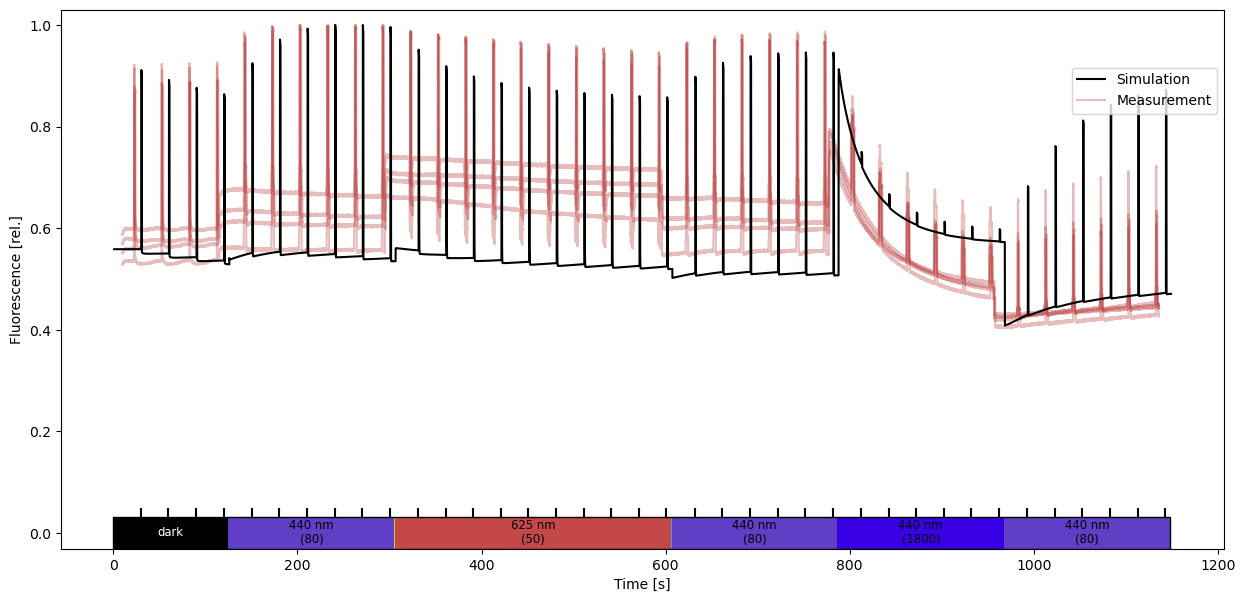

In [ ]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)

fig,ax= plt.subplots(figsize=(15,7))
dat = df.loc[:1126,idx["25", "white",:]]
dat_line = ax.plot(dat.index.to_numpy() + 10, dat.values, c="firebrick", label="Measurement", alpha=0.3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Fluorescence [rel.]")
ax.set_ylim(ymin=0)

# Plot the simulation on top
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = ax.plot(_s.get_time(), fluo_norm, c="black", label="Simulation")

handles = sim_line + [dat_line[0]]

ax.legend(
    handles = handles,
    loc="center right",
    bbox_to_anchor = (1,0.85)
)

ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.set_title("")
fnc.savefig_dated(fig, f"pamspplot_validation_singleplot", type=plot_format, path=figure_path, bbox_inches="tight")

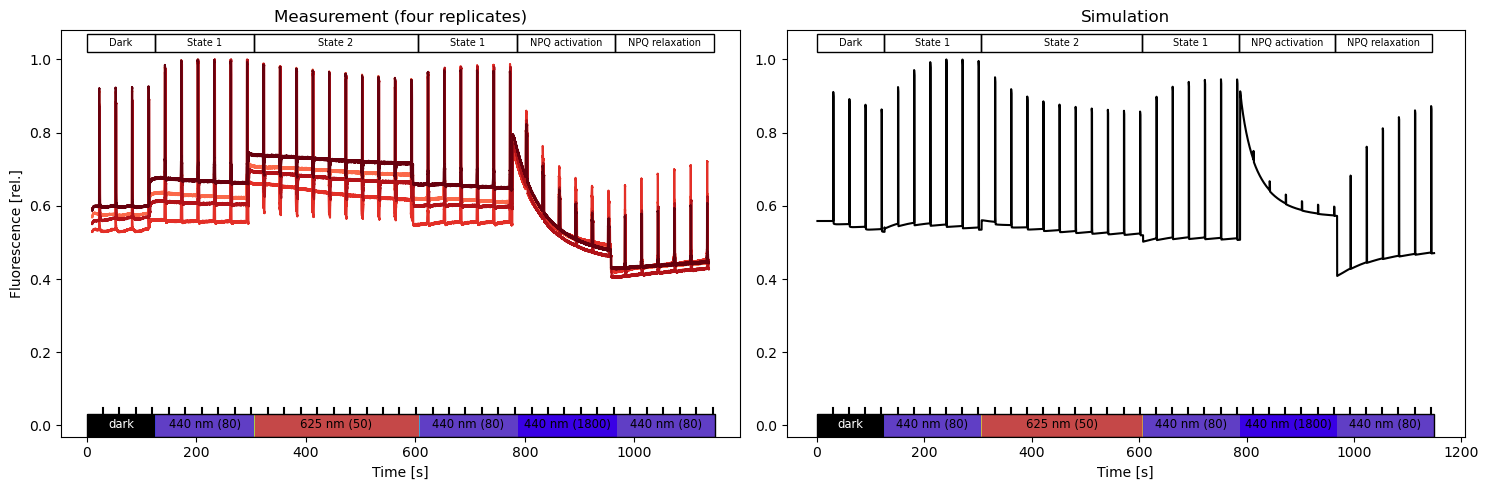

In [ ]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)

fig,axes= plt.subplots(1,2, figsize=(15,5))
dat = df.loc[:1126,idx["25", "white",:]]

colors = mpl.colormaps["Reds"](np.linspace(0.5,1,len(dat.columns)))
for i in range(len(dat.columns)):   
    dat_line = axes[0].plot(dat.index.to_numpy() + 10, dat.iloc[:,i], c=colors[i], label="Measurement")
axes[0].set_ylabel("Fluorescence [rel.]")
axes[0].set_title("Measurement (four replicates)")


# Plot the simulation on the side
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = axes[1].plot(_s.get_time(), fluo_norm, c="black", label="Simulation")
axes[1].set_title("Simulation")

for ax in axes:
    ax.set_xlabel("Time [s]")
    ax.set_ylim(ymin=0)
    ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)
    
    
    # Add phaseboxes
    ax = add_phasebox(ax, 0, 125, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 125, 305, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 305, 605, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 605, 785, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 785, 965, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 965, 1145, "NPQ relaxation", 0.05, 1.02)

# Share the y axis
axes[0].sharey(axes[1])
# axes[1].set_yticklabels([])

fig.tight_layout()
fnc.savefig_dated(fig, f"pamspplot_validation_dualplot", type=plot_format, path=figure_path, bbox_inches="tight")